## Setup

In [1]:
%pip install monai

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip show monai

Name: monai
Version: 1.4.0
Summary: AI Toolkit for Healthcare Imaging
Home-page: https://monai.io/
Author: MONAI Consortium
Author-email: monai.contact@gmail.com
License: Apache License 2.0
Location: c:\users\manav\miniconda3\envs\ml\lib\site-packages
Requires: numpy, torch
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
import monai
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    RandGaussianNoise,
    RandGaussianSmooth,
    Resize
)
from monai.utils import set_determinism
from tqdm.auto import tqdm

print_config()

c:\Users\manav\miniconda3\envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: c:\Users\<username>\miniconda3\envs\ML\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.13.1
Pillow version: 10.4.0
Tensorboard version: 2.10.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.1
tqdm version: 4.67.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.1.0
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.48.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UN

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\manav\AppData\Local\Temp\tmp1mt04f2_


In [5]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 0.00B [00:00, ?B/s]

MedNIST.tar.gz: 59.0MB [00:02, 28.3MB/s]                              

2025-04-06 18:07:24,287 - INFO - Downloaded: C:\Users\manav\AppData\Local\Temp\tmp1mt04f2_\MedNIST.tar.gz


2025-04-06 18:07:24,380 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2025-04-06 18:07:24,389 - INFO - Writing into directory: C:\Users\manav\AppData\Local\Temp\tmp1mt04f2_.


In [6]:
set_determinism(seed=42)

In [7]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [os.path.join(data_dir, class_names[i], x) for x in os.listdir(os.path.join(data_dir, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


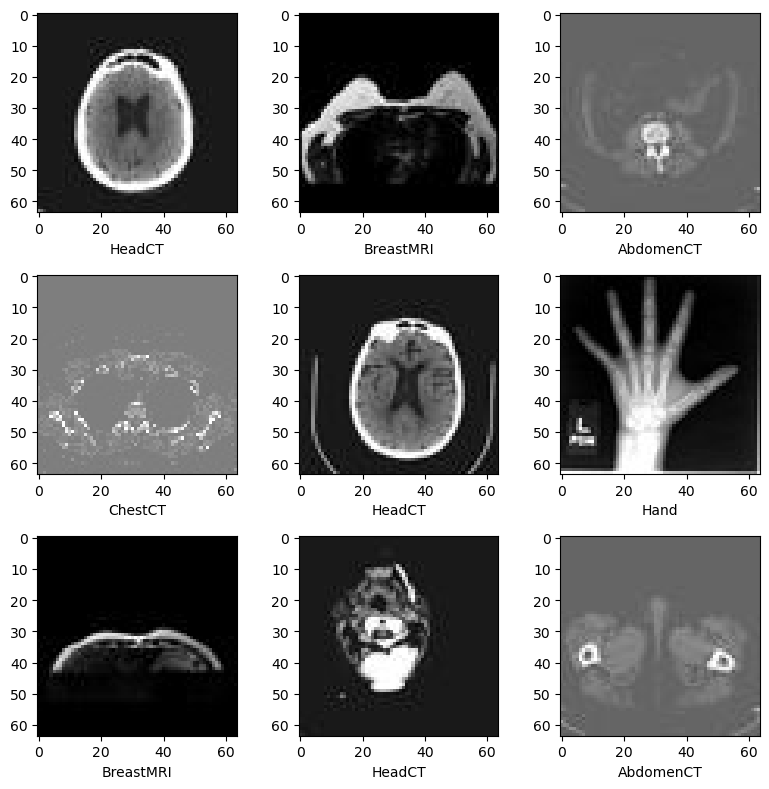

In [8]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [9]:
val_frac = 0.10
test_frac = 0.10
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


In [10]:
# Adding data augmentation
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),

        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),

        RandGaussianNoise(prob=0.3, mean=0.0, std=0.01), # adding more noise
        RandGaussianSmooth(prob=0.2, sigma_x=(0.5, 1.0), sigma_y=(0.5, 1.0)), # adding bluriness
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [11]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=500, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=400, num_workers=10)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=100, num_workers=0)

## Training Model

In [10]:
from monai.networks.nets import resnet50
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
model = resnet50(spatial_dims=2, n_input_channels=1, num_classes=num_class).to(device)

model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1024, bias=True),
    nn.SiLU(),
    nn.Dropout(0.01),
    nn.Linear(in_features=1024, out_features=6, bias=True)
)

def replace_relu_with_silu(module):
    for name, child in module.named_children():
        if isinstance(child, nn.ReLU):
            setattr(module, name, nn.SiLU())
        else:
            replace_relu_with_silu(child)

replace_relu_with_silu(model)

In [11]:
loss_function = torch.nn.CrossEntropyLoss()
max_epochs = 4

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2,
    momentum=0.9,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=max_epochs)
val_interval = 1
auc_metric = ROCAUCMetric()

In [12]:
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): SiLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): Bat

In [13]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
Epoch 1/4
1/94, train_loss: 1.8321
2/94, train_loss: 1.7212
3/94, train_loss: 1.7129
4/94, train_loss: 1.6979
5/94, train_loss: 1.6788
6/94, train_loss: 1.6637
7/94, train_loss: 1.6496
8/94, train_loss: 1.6707
9/94, train_loss: 1.6248
10/94, train_loss: 1.6238
11/94, train_loss: 1.5944
12/94, train_loss: 1.5692
13/94, train_loss: 1.5794
14/94, train_loss: 1.5536
15/94, train_loss: 1.5484
16/94, train_loss: 1.5122
17/94, train_loss: 1.5135
18/94, train_loss: 1.4880
19/94, train_loss: 1.5061
20/94, train_loss: 1.4899
21/94, train_loss: 1.4675
22/94, train_loss: 1.4392
23/94, train_loss: 1.4343
24/94, train_loss: 1.4583
25/94, train_loss: 1.4436
26/94, train_loss: 1.4066
27/94, train_loss: 1.3737
28/94, train_loss: 1.3775
29/94, train_loss: 1.3897
30/94, train_loss: 1.3898
31/94, train_loss: 1.3415
32/94, train_loss: 1.3733
33/94, train_loss: 1.3197
34/94, train_loss: 1.3163
35/94, train_loss: 1.3309
36/94, train_loss: 1.2943
37/94, train_loss: 1.2901
38/94, train_loss: 1.2918


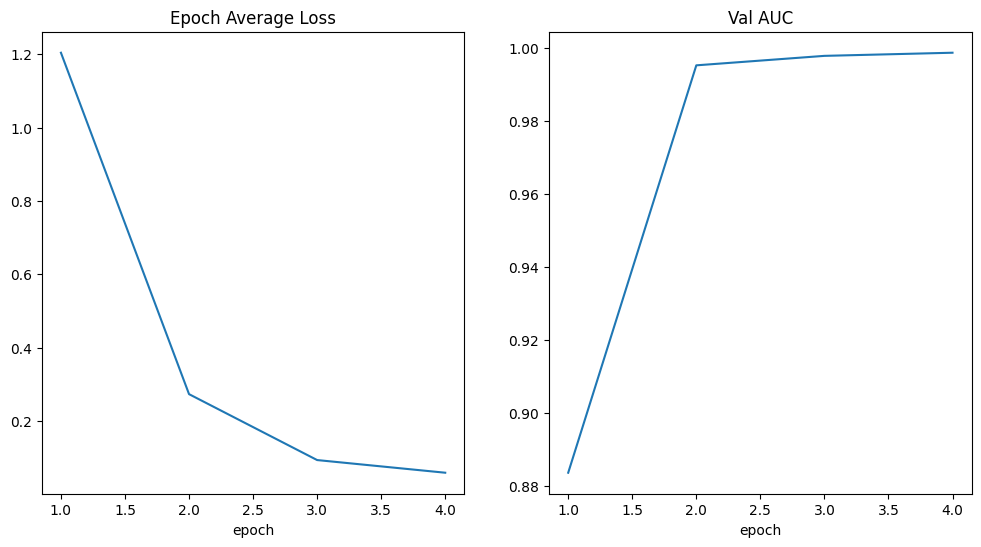

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [15]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [16]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9884    0.9961    0.9923      1030
   BreastMRI     1.0000    1.0000    1.0000       898
         CXR     0.9905    0.9957    0.9931       939
     ChestCT     0.9470    0.9990    0.9723      1002
        Hand     0.9939    0.9868    0.9903       985
      HeadCT     0.9969    0.9385    0.9668      1041

    accuracy                         0.9854      5895
   macro avg     0.9861    0.9860    0.9858      5895
weighted avg     0.9859    0.9854    0.9854      5895



In [17]:
if directory is None:
    shutil.rmtree(root_dir)

In [18]:
model_name = "resnet50_64x64_data_augmentation_different_architecture+optim"

In [19]:
torch.save(model.state_dict(), f"/content/{model_name}.pth")

## Inference

In [16]:
from monai.networks.nets import resnet50
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
model = resnet50(spatial_dims=2, n_input_channels=1, num_classes=num_class).to(device)

model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1024, bias=True),
    nn.SiLU(),
    nn.Dropout(0.01),
    nn.Linear(in_features=1024, out_features=6, bias=True)
)

def replace_relu_with_silu(module):
    for name, child in module.named_children():
        if isinstance(child, nn.ReLU):
            setattr(module, name, nn.SiLU())
        else:
            replace_relu_with_silu(child)

replace_relu_with_silu(model)

In [17]:
model_name = "resnet50_64x64_data_augmentation_different_architecture+optim"

In [18]:
model.load_state_dict(torch.load(f"{model_name}.pth"))

C:\Users\manav\AppData\Local\Temp\ipykernel_25700\3807799976.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_name}.pth"))


<All keys matched successfully>

In [19]:
# !pip install onnxruntime
# !pip install onnx

In [20]:
model.eval()
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): SiLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): Bat

In [21]:
# Converting to TorchScript + ONNX

example_input = torch.randn(100, 1, 64, 64).to(device) # Using 100 batches

# TorchScript (JIT)
jit_model = torch.jit.trace(model, example_input)
torch.jit.save(jit_model, f"{model_name}_ts.pt")

# ONNX
torch.onnx.export(
    model, example_input, f"{model_name}.onnx",
    input_names=["input"], output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)

In [22]:
# %pip install openvino==2025.0.0

In [23]:
!ovc "{model_name}.onnx" --compress_to_fp16
# compresses the OpenVINO model to float16

[ SUCCESS ] XML file: c:\Users\manav\OneDrive\Desktop\Deep Learning\resnet50_64x64_data_augmentation_different_architecture+optim.xml
[ SUCCESS ] BIN file: c:\Users\manav\OneDrive\Desktop\Deep Learning\resnet50_64x64_data_augmentation_different_architecture+optim.bin


c:\Users\manav\miniconda3\envs\ML\lib\importlib\util.py:247: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  self.__spec__.loader.exec_module(self)


In [24]:
import time
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

def evaluate_inference(model, dataloader, name):
    preds, labels = [], []
    start = time.time()

    for x, y in dataloader:
        y_pred = model(x)
        preds.extend(np.argmax(y_pred, axis=1)) # selecting the predicted labels here
        labels.extend(y.numpy()) # actual labels
    end = time.time() # final end time

    accuracy = accuracy_score(labels, preds)
    latency = (end - start) / len(dataloader.dataset) * 1000
    print(f"{name}: Accuracy = {accuracy:.4f}, Latency = {latency:.2f} ms/sample")
    return accuracy, latency

In [25]:
# Torch
# Running each model on CPU
from openvino.runtime import Core
import onnxruntime as ort



model.eval()
model.to("cpu")
def infer_torch(x):
    with torch.no_grad():
        return model(x).numpy()

# TorchScript
ts_model = torch.jit.load(f"{model_name}_ts.pt", map_location="cpu")
ts_model = torch.jit.optimize_for_inference(ts_model)
ts_model.eval()
def infer_ts(x):
    with torch.no_grad():
        return ts_model(x).numpy()

# ONNX
sess_options = ort.SessionOptions()
sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

onnx_session = ort.InferenceSession(f"{model_name}.onnx", sess_options)
def infer_onnx(x):
    input_name = onnx_session.get_inputs()[0].name
    return onnx_session.run(None, {input_name: x.numpy()})[0]

# OpenVINO
core = Core()
ov_model = core.read_model(f"{model_name}.xml")
compiled_model = core.compile_model(ov_model, "CPU")

input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

def infer_openvino(x):
    return compiled_model({input_layer.any_name: x.numpy()})[output_layer.any_name]

c:\Users\manav\miniconda3\envs\ML\lib\importlib\util.py:247: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  self.__spec__.loader.exec_module(self)


In [26]:
accs, lats = {}, {}

accs["Torch"], lats["Torch"] = evaluate_inference(infer_torch, test_loader, "PyTorch")
accs["TorchScript"], lats["TorchScript"] = evaluate_inference(infer_ts, test_loader, "TorchScript")
accs["ONNX"], lats["ONNX"] = evaluate_inference(infer_onnx, test_loader, "ONNX")
accs["OpenVINO"], lats["OpenVINO"] = evaluate_inference(infer_openvino, test_loader, "OpenVINO")

PyTorch: Accuracy = 0.9908, Latency = 13.39 ms/sample
TorchScript: Accuracy = 0.9908, Latency = 7.35 ms/sample
ONNX: Accuracy = 0.9908, Latency = 5.65 ms/sample
OpenVINO: Accuracy = 0.9908, Latency = 5.89 ms/sample


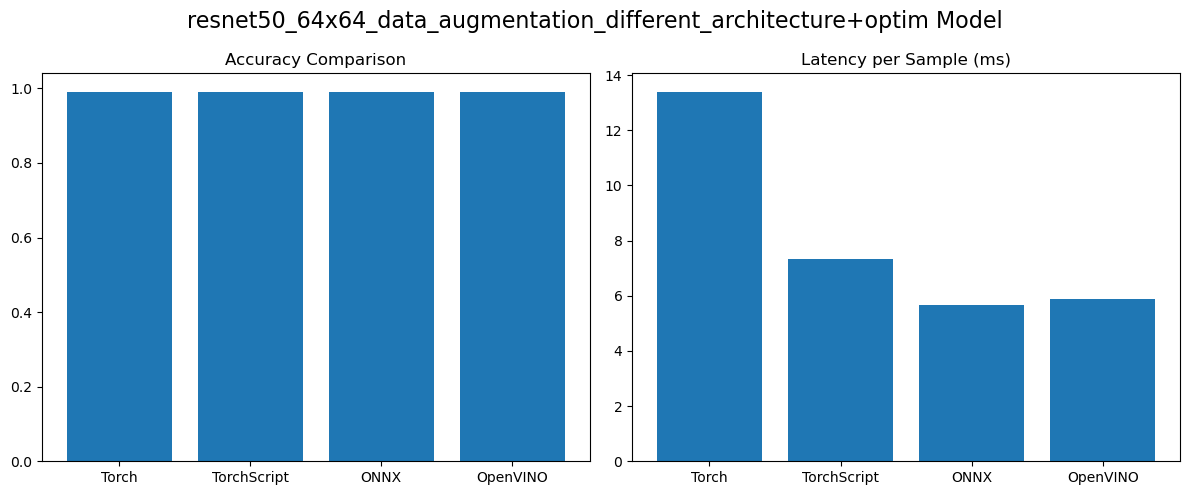

In [27]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(accs.keys(), accs.values())
ax1.set_title("Accuracy Comparison")
ax2.bar(lats.keys(), lats.values())
ax2.set_title("Latency per Sample (ms)")
plt.suptitle(f"{model_name} Model", fontsize=16)
plt.tight_layout()
plt.show()

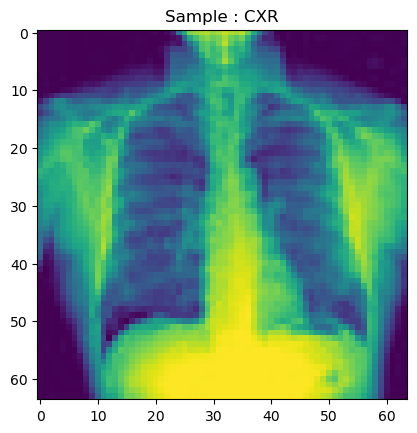

In [31]:
# Let's try one individual image
from PIL import Image
import onnxruntime

# Transforms on test image
inference_transform = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity(),
])

sample_path = test_x[21]  # Using the test set image to check for singular image
idx = image_files_list.index(sample_path)
sample_label = image_class[idx]
sample_class_name = class_names[sample_label]


img = Image.open(sample_path)
plt.imshow(img)
plt.title(f"Sample : {sample_class_name}")

image_tensor = inference_transform(sample_path)
input_tensor = image_tensor.unsqueeze(0)  # (1, 1, 64, 64)
input_arr = input_tensor.numpy().astype(np.float32)


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [32]:
# ONNX Inference
sess_options = ort.SessionOptions()
sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

onnx_session = ort.InferenceSession(f"{model_name}.onnx", sess_options)
input_name = onnx_session.get_inputs()[0].name

start = time.time()
ort_output = onnx_session.run([], {input_name: input_arr})[0]
end = time.time()


probs = softmax(ort_output.flatten())
top5_indices = np.argsort(-probs)[:7]

print("\nTop-5 Predictions:")
for rank, i in enumerate(top5_indices):
    print(f"{rank+1}. {class_names[i]:<12} — {probs[i]:.4f}")

print(f"\n ONNX Top-1 Prediction: {class_names[top5_indices[0]]}")
print(f"Inference time: {(end - start) * 1000:.2f} ms")


Top-5 Predictions:
1. CXR          — 0.9963
2. ChestCT      — 0.0014
3. Hand         — 0.0011
4. AbdomenCT    — 0.0006
5. HeadCT       — 0.0004
6. BreastMRI    — 0.0000

 ONNX Top-1 Prediction: CXR
Inference time: 9.03 ms


In [33]:
# OpenVINO inference
core = Core()
ov_model = core.read_model(f"{model_name}.xml")
compiled_model = core.compile_model(ov_model, "CPU")
output_layer = compiled_model.output(0)

start = time.time()
ort_output = compiled_model([input_arr])[output_layer]
end = time.time()

probs = softmax(ort_output.flatten())
top5_indices = np.argsort(-probs)[:7]

print("\nTop-5 Predictions:")
for rank, i in enumerate(top5_indices):
    print(f"{rank+1}. {class_names[i]:<12} — {probs[i]:.4f}")

print(f"\n OpenVINO Top-1 Prediction: {class_names[top5_indices[0]]}")
print(f"Inference time: {(end - start) * 1000:.2f} ms")


Top-5 Predictions:
1. CXR          — 0.9963
2. ChestCT      — 0.0014
3. Hand         — 0.0011
4. AbdomenCT    — 0.0006
5. HeadCT       — 0.0004
6. BreastMRI    — 0.0000

 OpenVINO Top-1 Prediction: CXR
Inference time: 35.06 ms


---